<a href="https://colab.research.google.com/github/matjesg/deepflash2/blob/master/paper/benchmark_unet_2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# deepflash2 - U-Net benchmark

> This notebook reproduces the *U-Net* results of the deepflash2 [paper](https://arxiv.org/abs/2111.06693) for semantic and instance segmentation.

- **Data**: The data is available on [Google Drive](https://drive.google.com/drive/folders/1r9AqP9qW9JThbMIvT0jhoA5mPxWEeIjs?usp=sharing). To use the data in Google Colab, create a [shortcut](https://support.google.com/drive/answer/9700156?hl=en&co=GENIE.Platform%3DDesktop) of the data folder in your personal Google Drive.

- **Models**: The trained models are also available on [Google Drive](https://drive.google.com/drive/folders/1BZRrRTDuJw5EoBqz1RWoFKZ7eq2kEwxm?usp=sharing). To use the trained models for prediction, create a [shortcut](https://support.google.com/drive/answer/9700156?hl=en&co=GENIE.Platform%3DDesktop) of the data folder in your personal Google Drive.


*References*:

Griebel, M., Segebarth, D., Stein, N., Schukraft, N., Tovote, P., Blum, R., & Flath, C. M. (2021). Deep-learning in the bioimaging wild: Handling ambiguous data with deepflash2. arXiv preprint arXiv:2111.06693.

Falk, T., Mai, D., Bensch, R., Çiçek, Ö., Abdulkadir, A., Marrakchi, Y., ... & Ronneberger, O. (2019). U-Net: deep learning for cell counting, detection, and morphometry. Nature methods, 16(1), 67-70.


## Setup

- Install dependecies
- Connect to drive

In [ ]:
!pip install 'h5py<3.0.0'
!wget https://raw.githubusercontent.com/matjesg/deepflash2/master/deepflash2/paper/unet.py

In [ ]:
# Imports
%tensorflow_version 1.x
import tensorflow as tf
import imageio
import cv2
import tifffile
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.color import label2rgb
from shutil import copyfile
import unet

In [ ]:
# Connect to drive
try:
  from google.colab import drive
  drive.mount('/gdrive')
except:
  print('Google Drive is not available.')

Mounted at /gdrive


## Settings

Choose dataset from `PV_in_HC`,  `cFOS_in_HC`, `mScarlet_in_PAG`,  `YFP_in_CTX`, `GFAP_in_HC`

In [ ]:
DATASET = 'GFAP_in_HC'
SEED = 0 # We used seeds [0,1,2] in our experiemnts
OUTPUT_PATH = Path("/content/predictions") # Save predictions here
MODEL_PATH = Path("/content/models") # Save models here
DATA_PATH = Path('/gdrive/MyDrive/deepflash2-paper/data')
TRAINED_MODEL_PATH= Path('/gdrive/MyDrive/benchmark_models/unet_2019/')

TILE_SHAPE = (540,540)
PADDING = (184,184)
EL_SIZE = [None, None] 
CHANNELS = 1

# Derived via Bayesian Hyperparameter Optimization on Weights & Biases 
hyperparams_dict = {
    'cFOS_in_HC': {
        'border_weight_sigma_px': 2,
        'border_weight_factor':44,
        'foreground_background_ratio':0.23
        },
    'PV_in_HC': {
        'border_weight_sigma_px': 10,
        'border_weight_factor':25,
        'foreground_background_ratio':0.66
        },
    'mScarlet_in_PAG':{
        'border_weight_sigma_px': 10,
        'border_weight_factor':15,
        'foreground_background_ratio':0.66
        },
    'YFP_in_CTX':{
        'border_weight_sigma_px': 5,
        'border_weight_factor':15,
        'foreground_background_ratio':0.85
        },
    'GFAP_in_HC':{
        'border_weight_sigma_px': 1,
        'border_weight_factor': 1,
        'foreground_background_ratio':0.85
        },  
}

border_weight_sigma_px=hyperparams_dict[DATASET]['border_weight_sigma_px']
border_weight_factor=hyperparams_dict[DATASET]['border_weight_factor']
foreground_background_ratio=hyperparams_dict[DATASET]['foreground_background_ratio']

## Data preprocessing

- Loading data in RAM
- Plot images and masks to show if they are correctly loaded

(12, 540, 540, 1)


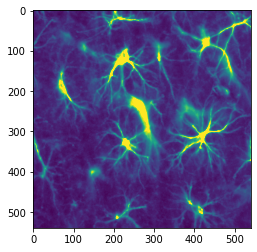

(540, 540)


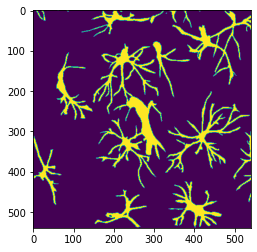

(8, 540, 540, 1)


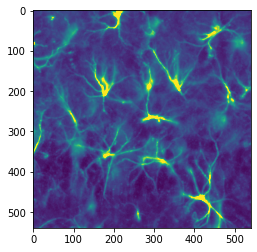

In [ ]:
# Load
path = DATA_PATH/DATASET
train_image_path = path/'train'/'images'
test_image_path = path/'test'/'images'
train_masks_path = path/'train'/'masks_STAPLE'
label_fn = lambda x: train_masks_path/f'{x.stem}_mask.png'

files = sorted([x for x in train_image_path.iterdir() if not x.name.startswith('.')])
files_test = [x for x in test_image_path.iterdir() if not x.name.startswith('.')]

# Train images
images = [imageio.imread(f) for f in files]
images = np.expand_dims(images, axis=-1)/255
print(images.shape)
plt.imshow(images[0,...,0], vmax=0.5)
plt.show()

# Train masks
masks = [imageio.imread(label_fn(f))//255 for f in files]
print(masks[0].shape)
assert np.array(masks).max() == 1 
plt.imshow(masks[0])
plt.show()

# Test images
images_test = [imageio.imread(f) for f in files_test]
images_test = np.expand_dims(images_test, axis=-1)/255
data_test = [{'rawdata': img, 'element_size_um': EL_SIZE} for img in images_test]
print(images_test.shape)
plt.imshow(images_test[0,...,0], vmax=0.5)
plt.show()


## Train models

- Using the unet train [script](https://raw.githubusercontent.com/matjesg/deepflash2/master/deepflash2/paper/benchmarks/unet.py) provided by the authors (Falk et al.)
- Epochs are computes such that at least 10k iterations are reached
- You can skip this step use the trained models from our paper (see next section).

In [ ]:
images_train, images_val, masks_train, masks_val = train_test_split(images,masks, test_size=0.1, random_state=SEED)
data_train = [{'rawdata': img, 'element_size_um': EL_SIZE} for img in images_train] 
data_val = [{'rawdata': img, 'element_size_um': EL_SIZE} for img in images_val] 

train_generator = unet.DataAugmentationGenerator(data = data_train, 
                                              classlabels=masks_train,
                                              instancelabels=None,
                                              tile_shape = TILE_SHAPE, 
                                              padding= PADDING,
                                              batch_size = 4,
                                              n_classes=2,
                                              ignore=None,
                                              weights=None,
                                              element_size_um=None,
                                              rotation_range_deg=(0, 360),
                                              flip=True,
                                              deformation_grid=(150, 150),
                                              deformation_magnitude=(10, 10),
                                              value_minimum_range=(0, 0),
                                              value_maximum_range=(0.0, 1),
                                              value_slope_range=(1, 1),
                                              shuffle=True,
                                              border_weight_sigma_px=border_weight_sigma_px, 
                                              border_weight_factor=border_weight_factor,
                                              foreground_background_ratio=foreground_background_ratio
                                              )


tile_generator_val = unet.TileGenerator(data = data_val, 
                                    classlabels=masks_val,
                                    instancelabels=None,
                                    tile_shape = TILE_SHAPE, 
                                    padding= PADDING,
                                    n_classes=2,
                                    ignore=None,
                                    weights=None,
                                    element_size_um=None,
                                    border_weight_sigma_px=border_weight_sigma_px, 
                                    border_weight_factor=border_weight_factor,
                                    foreground_background_ratio=foreground_background_ratio)
model = unet.Unet2D(snapshot=None, 
                n_channels=CHANNELS, 
                n_classes=2, 
                n_levels=4,
                n_features=64, 
                name="U-Net")

n_epochs = 1e4/len(train_generator)
n_epochs = int(n_epochs - n_epochs%50 + 50)
cp_name = f'model.{n_epochs:04d}.h5'

model_dir = MODEL_PATH/DATASET/f'{SEED+1}'
log_dir = model_dir/'logs'
log_dir.mkdir(exist_ok=True, parents=True)
hist = model.train(train_generator, 
                  validation_generator=tile_generator_val,
                  validation_freq=50,
                  n_epochs=n_epochs, 
                  snapshot_interval=50, 
                  snapshot_prefix='model',
                  log_dir=log_dir.as_posix()
                  )

copyfile(cp_name, model_dir/cp_name)

## Prediction on test set

Labels are converted and saved to
- Semantic segmentation masks (.png)
- Instance segmentation masks (.tif) using the connected components algorithm

To ensure reproducibilty we will use the trained models from our paper!

Processing test sample 1 / 8
  Normalizing intensity range...
  Tiling...
Processing test sample 2 / 8
  Normalizing intensity range...
  Tiling...
Processing test sample 3 / 8
  Normalizing intensity range...
  Tiling...
Processing test sample 4 / 8
  Normalizing intensity range...
  Tiling...
Processing test sample 5 / 8
  Normalizing intensity range...
  Tiling...
Processing test sample 6 / 8
  Normalizing intensity range...
  Tiling...
Processing test sample 7 / 8
  Normalizing intensity range...
  Tiling...
Processing test sample 8 / 8
  Normalizing intensity range...
  Tiling...
/gdrive/MyDrive/benchmark_models/unet_2019/1/GFAP_in_HC/model.5050.h5


/tensorflow-1.15.2/python3.7/keras/engine/training_utils.py:819: UserWarning: Output softmax_9 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to softmax_9.
  'be expecting any data to be passed to {0}.'.format(name))


1/1 [==============================] - 0s 223ms/step
2375-1.png


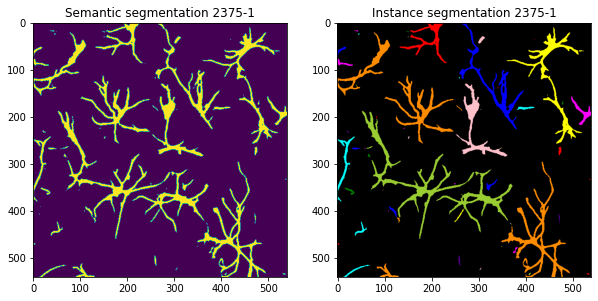

2376-2.png


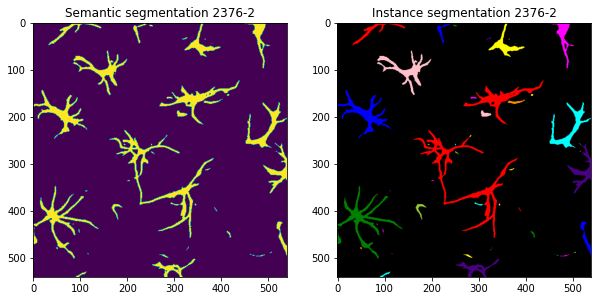

2378-3.png


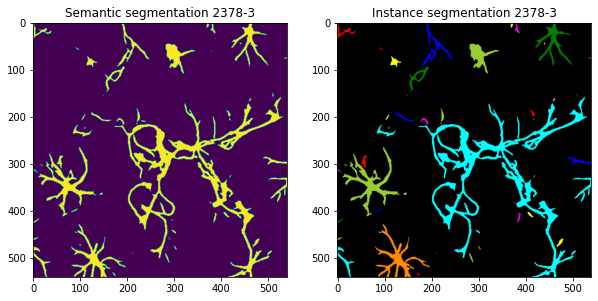

2375-0.png


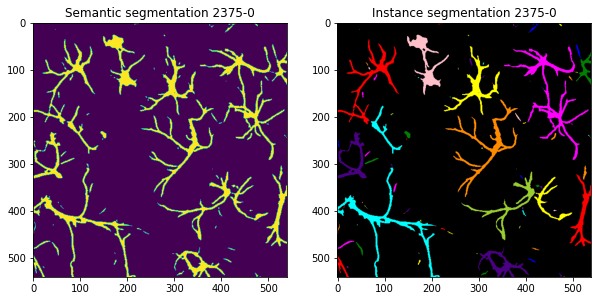

2376-3.png


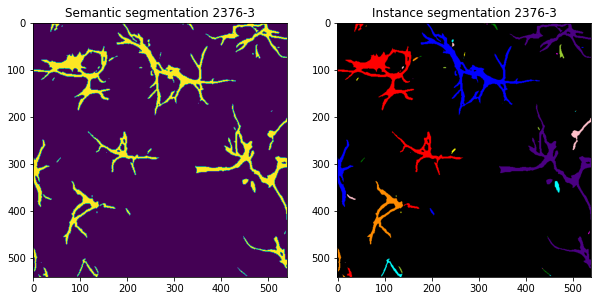

2377-2.png


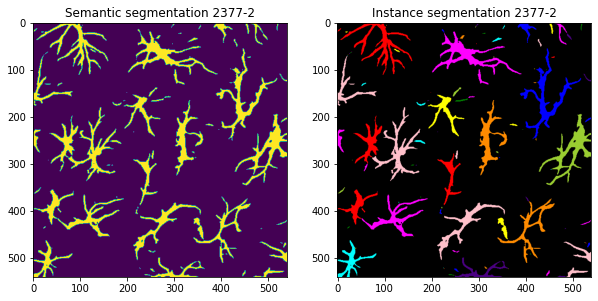

2377-0.png


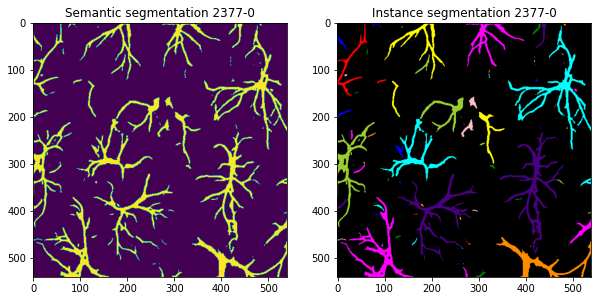

2378-2.png


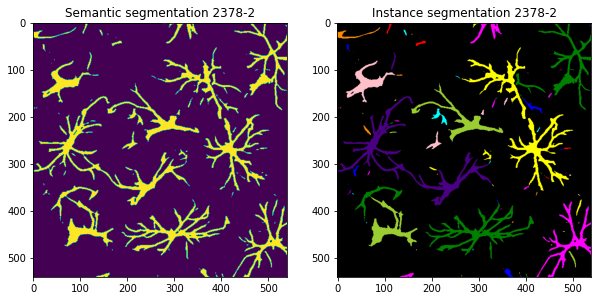

In [ ]:
tile_generator_test = unet.TileGenerator(data = data_test, 
                                      classlabels=None,
                                      instancelabels=None,
                                      tile_shape = TILE_SHAPE, 
                                      padding= PADDING,
                                      n_classes=2,
                                      ignore=None,
                                      weights=None,
                                      element_size_um=None,
                                      border_weight_sigma_px=border_weight_sigma_px, 
                                      border_weight_factor=border_weight_factor,
                                      foreground_background_ratio=foreground_background_ratio)

test_model_cp = [x for x in (TRAINED_MODEL_PATH/f'{SEED+1}'/DATASET).iterdir() if x.name.startswith('model')][0]
print(test_model_cp)
test_model = unet.Unet2D(snapshot=test_model_cp.as_posix(), 
                      n_channels=CHANNELS, 
                      n_classes=2, 
                      n_levels=4,
                      n_features=64, 
                      name="U-Net")

smscores, segmentations = test_model.predict(tile_generator=tile_generator_test)

prediction_path = OUTPUT_PATH/DATASET
for i, f in enumerate(files_test):
      print(f.name)
      idx = f.stem
      pred = segmentations[i]
      # Save semantic segmentation prediction
      masks_path = prediction_path/'masks'
      masks_path.mkdir(parents=True, exist_ok=True)
      imageio.imwrite(masks_path/f'{idx}.png', (pred*255).astype('uint8'))

      # Save instance segmentation prediction
      instance_masks_path = prediction_path/'instance_masks'
      instance_masks_path.mkdir(exist_ok=True)
      _, label_msk = cv2.connectedComponents(pred.astype('uint8'), connectivity=4)
      tifffile.imwrite(instance_masks_path/f'{idx}.tif', label_msk.astype('int16'), compress=6)

      # Plot
      fig, axs = plt.subplots(ncols=2, figsize=(10,5))
      axs[0].imshow(label_msk>0)
      axs[0].set_title(f'Semantic segmentation {idx}')
      axs[1].imshow(label2rgb(label_msk, bg_label=0))
      axs[1].set_title(f'Instance segmentation {idx}')
      plt.show()